In [38]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from time import time

# Method 1: Mean Squared Displacement Approach
The diffusion coefficient of a system can be computed from the slop of the mean squared displacement as a function of time:
$$D=\frac{1}{6}\frac{\mathrm{d}}{\mathrm{d}t}\langle\frac{1}{N}\sum_{i=1}^{N}(\bf{r}_i(t)-\bf{r}_i(0))^2\rangle$$
where $N$ is the number of particles. 
The procedure of using this method to compute the diffusion coefficient is as follows:
- Run an NpT MD to equilibriate the system under the target temperature and pressure
- Pick up several initial equilibrated configurations from the NpT run
- Run several independent NVE MD simulations with the several initial configurations
- Read the trajectory and unwrap the atom positions
- Compute the displacement from the original positions; repeat this process by chooing different original positions
- Compute the average of the squared displacements along the trajectory
- Use linear fitting to obtain the slope of the mean squared displacement and divide it by 6

The following steps are necessary but are not done here:
- Compute the diffusion coefficients for the several MD simulations
- Compute the standard deviation of the diffusion coefficient

In [116]:
# The box dimensions
xlo=1.3116195752337667e-01
xhi=1.6368838042477247e+01
ylo=1.3195687847856341e-01
yhi=1.6468043121521966e+01
zlo=1.3116195752337667e-01
zhi=1.6368838042477247e+01
Lx=xhi-xlo
Ly=yhi-ylo
Lz=zhi-zlo
cell=np.array([Lx, Ly, Lz])

In [117]:
# Read the trajectory
xyz = []
Natom = 432
Nsamp = 10001
with open("h2o.xyz", "r") as f:
    for i in range(Nsamp):
        for j in range(9):
            f.readline()
        for j in range(Natom):
            xyz.append(f.readline().split())
xyz = np.array(xyz, dtype = "float").reshape(Nsamp, Natom, 11)

In [56]:
# Read the LAMMPS log file
log = np.loadtxt("log.lammps", skiprows=88, max_rows=10001)

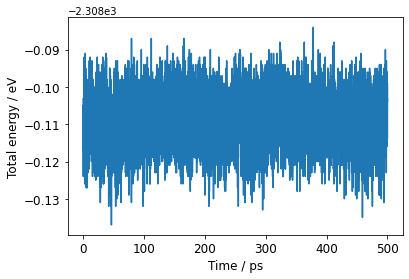

In [120]:
# The Hamiltonian of the system is conserved in the NVE ensemble.
plt.xlabel("Time / ps", fontsize=12)
plt.ylabel("Total energy / eV", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(log[:, 0]*0.5*1e-3, log[:, 4])

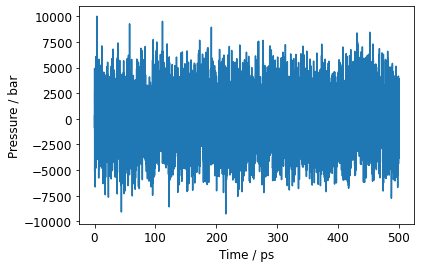

In [121]:
plt.xlabel("Time / ps", fontsize=12)
plt.ylabel("Pressure / bar", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(log[:, 0]*0.5*1e-3, log[:, 5])

## 1-11 colums of the xyz file:
- 1: atom id
- 2: type
- 3-5: coordinates
- 6-9: velocities
- 10-12: periodic images

In [127]:
print(xyz[0, :5, :])

[[  1.         1.         0.95596    7.55386    3.10143   -0.679068
   -3.51712   -2.96897    0.         0.         0.      ]
 [  2.         2.         0.950964   7.35593    2.14006   18.3756
  -22.632     -2.88356    0.         0.         0.      ]
 [  3.         2.        16.2526     8.13124    3.04724   13.1048
   -2.48085  -22.8407    -1.         0.         0.      ]
 [  4.         1.         4.84877    0.803498   6.79073    4.37708
    0.20522   -2.47448    0.         0.         0.      ]
 [  5.         2.         5.41174    1.35812    7.40244   -9.18087
   -7.16353  -19.5252     0.         0.         0.      ]]


In [64]:
# unwrap the coordinate
coord = xyz[:, :, 2:5] + xyz[:, :, 8:11]*cell

In [65]:
# velocities
vel = xyz[:, :, 5:8]

Now we compute the mean squared displacements. $N_{\mathrm{samp}}$ is the number of samples to compute the ensemble average of $(\bf{r}_i(t)-\bf{r}_i(0))^2$ for a specific $t$, where $t=0.05\times i$ ps, $i = 0, 1, ..., N_{\mathrm{traj}}$.

The diffusion coefficient can be calculated for both the whole system and indivisual elements. In the system of liquid water, both O and H should have similar diffusion coefficients to that of H$_2$O:
$$D_{\mathrm{H}}=D_{\mathrm{H}}=D_{\mathrm{H_2O}}.$$

Note that the only difference should be the number of atoms when doing the average over atoms.

In [128]:
t1 = time()
Nsum = 500
Ntraj = 200
msds = np.zeros([Nsum, Ntraj])
msdOs = np.zeros([Nsum, Ntraj])
msdHs = np.zeros([Nsum, Ntraj])
for i in range(Nsum):
    msds[i] = (((coord[i:i+Ntraj]-coord[i])**2).sum(axis=2)).mean(axis=1)
    msdOs[i] = (((coord[i:i+Ntraj, ::3]-coord[i, ::3])**2).sum(axis=2)).mean(axis=1)
    msdHs[i] = ((((coord[i:i+Ntraj, 1::3]-coord[i, 1::3])**2).sum(axis=2)).mean(axis=1) + (((coord[i:i+Ntraj, 2::3]-coord[i, 2::3])**2).sum(axis=2)).mean(axis=1))/2
t2 = time()
print("%d means cost %.4f s."%(Nsum, t2-t1))

500 means cost 1.7345 s.


In [129]:
msd_mean = msds.mean(axis=0)
msdO_mean = msdOs.mean(axis=0)
msdH_mean = msdHs.mean(axis=0)

In [130]:
msd=(((coord[:0+Ntraj]-coord[0])**2).sum(axis=2)).mean(axis=1)

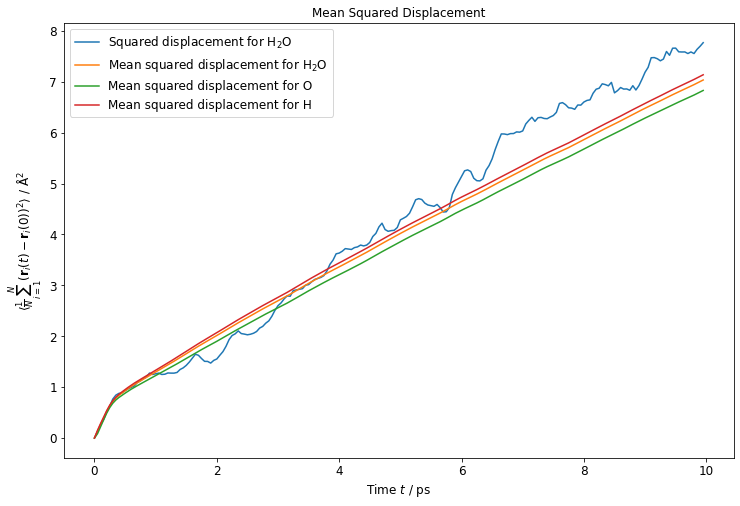

In [147]:
plt.figure(figsize=(12, 8))
plt.title("Mean Squared Displacement", fontsize=12)
plt.xlabel("Time $t$ / ps", fontsize=12)
plt.ylabel("$\langle\\frac{1}{N}\\sum_{i=1}^{N}(\mathbf{r}_i(t)-\mathbf{r}_i(0))^2\\rangle$ / $\mathrm{\AA}^2$", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(0.05*np.arange(Ntraj), msd, label="Squared displacement for H$_2$O")
plt.plot(0.05*np.arange(Ntraj), msd_mean, label="Mean squared displacement for H$_2$O")
plt.plot(0.05*np.arange(Ntraj), msdO_mean, label="Mean squared displacement for O")
plt.plot(0.05*np.arange(Ntraj), msdH_mean, label="Mean squared displacement for H")
plt.legend(fontsize=12)

Now we perform the linear fitting of the RMSD from 1 to 10 ps.

In [148]:
linefit = np.polyfit(0.05*np.arange(20, Ntraj), msd_mean[20:], deg=1)
linefitO = np.polyfit(0.05*np.arange(20, Ntraj), msdO_mean[20:], deg=1)
linefitH = np.polyfit(0.05*np.arange(20, Ntraj), msdH_mean[20:], deg=1)

In [151]:
print(linefit[0]/6, linefitO[0]/6, linefitH[0]/6)

0.1062518978364375 0.10427193933001433 0.10724187708964912


Therefore the diffusion coefficients are:
$$D_{\mathrm{H_2O}}=0.1062\ \mathrm{Å^2\ /\ ps}$$
$$D_{\mathrm{O}}=0.1043\ \mathrm{Å^2\ /\ ps}$$
$$D_{\mathrm{H}}=0.1072\ \mathrm{Å^2\ /\ ps}$$

Note that we omitted the process of computing the statistical error, but it is necessary.

# Method 2: Velocity Auto-correlation Function Approach

In [114]:
t1 = time()
Nsum = 100
Ntraj = 10
vacf = np.zeros(Ntraj)
# msdOs = np.zeros([Nsum, Ntraj])
# msdHs = np.zeros([Nsum, Ntraj])
for i in range(Ntraj):
    vacf[i] = (((vel[:Nsum]*vel[i:i+Nsum]).sum(axis=2)).mean(axis=1)).mean(axis=0)
#     msdOs[i] = (((coord[i:i+Ntraj, ::3]-coord[i, ::3])**2).sum(axis=2)).mean(axis=1)
#     msdHs[i] = ((((coord[i:i+Ntraj, 1::3]-coord[i, 1::3])**2).sum(axis=2)).mean(axis=1) + (((coord[i:i+Ntraj, 2::3]-coord[i, 2::3])**2).sum(axis=2)).mean(axis=1))/2
t2 = time()
print("%d means cost %.4f s."%(Nsum, t2-t1))

100 means cost 0.0149 s.


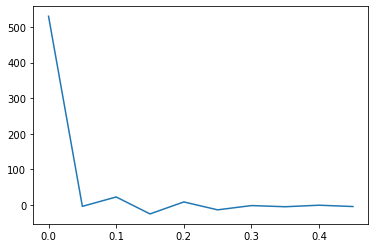

In [115]:
plt.plot(0.05*np.arange(Ntraj), vacf)

In [77]:
np.trapz(vacf, 0.05*np.arange(Ntraj))

12.846768187081345